# Proyecto 2 Sentimientos - Machine Learning.

***
***

## Integrantes:

- Diryon Yonith Mora Romero.
- Laura Valentina Gonzalez Rodriguez.

***
***

## Carga de Liberias Utilizadas.

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from sklearn.feature_selection import f_classif, SelectFwe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
import random

***
***

## Descripción del Dataset.

El conjunto de datos que se va a utilizar para la clasificación de sentimientos de señales de voz es un conjunto de atributos extraídos de grabaciones de voz de personas que han hablado en un estado emocional de enojo, tristeza o felicidad. Cada grabación de voz se ha sometido a un proceso de análisis y se han extraído 18 atributos que describen diferentes características de la señal acústica, explicada brevemente después. El objetivo del proyecto es utilizar una red neuronal para clasificar estas señales de voz según el sentimiento que transmiten: enojo, tristeza o felicidad. Se espera que la red neuronal pueda aprender a identificar patrones y relaciones en los datos que permitan una clasificación precisa y eficiente de las señales de voz en función de su estado emocional.

1. **meanfreq**: La frecuencia media (en kHz).
1. **sd**: La desviación estándar de la frecuencia.
1. **median**: La mediana de la frecuencia (en kHz).
1. **Q25**: El primer cuartil o Q1 de la frecuencia (en kHz).
1. **Q75**: El tercer cuartil o Q3 de la frecuencia (en kHz).
1. **IQR**: El rango intercuartílico (en kHz).
1. **skew**: Medida de la asimetría o el grado de distorsión de la distribución normal.
1. **kurt**: Medida estadística que determina qué tanto varían las colas de la distribución de las de una distribución normal.
1. **sp.ent**: Entropía espectral. Es una medida de irregularidad en la señal.
1. **sfm**: The spectral flatness o coeficiente de tonalidad. Una medida en decibeles que caracteriza el tono de un sonido.
1. **mode**: La moda en la frecuencia.
1. **centroid**: El centroide espectral, indica en dónde está ubicado el centro de masa del espectro.
1. **meanfun**: El promedio de la frecuencia fundamental medida a lo largo de la señal acústica.
1. **minfun**: El mínimo de la frecuencia fundamental medida a lo largo de la señal acústica.
1. **maxfun**: El máximo de la frecuencia fundamental medida a lo largo de la señal acústica.
1. **meandom**: El promedio de la frecuencia dominante medida a lo largo de la señal acústica.
1. **mindom**: El mínimo de la frecuencia dominante medida a lo largo de la señal acústica.
1. **maxdom**: El máximo de la frecuencia dominante medida a lo largo de la señal acústica.
1. **dfrange**: El rango de la frecuencia dominante medida a lo largo de la señal acústica.
1. **modindx**: El índice de modulación.
1. **lables**: El sentimiento asociado a la señal de voz, que puede ser enojado, triste o feliz.

***
***

## Preparación de las Variables.

En el conjunto de datos proporcionado, se han identificado tres columnas que parecen ser atributos de tipo índice, a saber, **Column1**, **Unnamed: 0** y **X**. Estas columnas no parecen aportar información relevante para el problema de clasificación planteado, por lo que se ha tomado la decisión de eliminarlas del conjunto de datos antes de realizar el análisis y modelado de los datos. Al eliminar estos atributos, se simplificará la tarea de clasificación y se reducirá el ruido en los datos, lo que podría resultar en una mayor precisión de los modelos de aprendizaje automático utilizados. Además, la eliminación de estos atributos no afectará la interpretación de los resultados ni la comprensión del problema en cuestión, ya que se trata de atributos que no tienen un significado intrínseco o relevancia conceptual en el contexto de las señales de voz y el análisis de sentimientos.

In [277]:
df = pd.read_csv("emotions_by_voice registers.csv")
df = df.drop(df.columns[[0, 1, 2]], axis=1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  909 non-null    float64
 1   sd        909 non-null    float64
 2   median    909 non-null    float64
 3   Q25       909 non-null    float64
 4   Q75       909 non-null    float64
 5   IQR       909 non-null    float64
 6   skew      909 non-null    float64
 7   kurt      909 non-null    float64
 8   sp.ent    909 non-null    float64
 9   sfm       909 non-null    float64
 10  mode      909 non-null    float64
 11  centroid  909 non-null    float64
 12  meanfun   909 non-null    float64
 13  minfun    909 non-null    float64
 14  maxfun    909 non-null    float64
 15  meandom   909 non-null    float64
 16  mindom    909 non-null    float64
 17  maxdom    909 non-null    float64
 18  dfrange   909 non-null    float64
 19  modindx   909 non-null    float64
 20  label     909 non-null    object

In [278]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.869088,2.863717,0.923566,0.307220,...,0.181338,0.137742,0.023022,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,sad
1,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,1.191767,3.878650,0.918848,0.298859,...,0.186897,0.121811,0.018412,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,sad
2,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,1.312690,4.589995,0.919519,0.313069,...,0.189102,0.123758,0.083333,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,sad
3,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,1.096409,3.680995,0.921361,0.329295,...,0.183036,0.128469,0.044693,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,sad
4,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,1.386837,5.031744,0.926238,0.337047,...,0.168793,0.109720,0.022472,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,sad


Para poder utilizar una red neuronal y predecir valores categóricos, es necesario convertir la variable objetivo en variables numericas mediante la técnica de "Label Encoding". En este caso, se ajusta un codificador a los valores únicos de una columna de un marco de datos, y luego se transforma la columna con el codificador para asignar un valor numérico único a cada etiqueta.

In [279]:
target = "label"

le = LabelEncoder()
le.fit(df[target])

df[target] = le.transform(df[target])
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.869088,2.863717,0.923566,0.307220,...,0.181338,0.137742,0.023022,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,2
1,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,1.191767,3.878650,0.918848,0.298859,...,0.186897,0.121811,0.018412,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,2
2,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,1.312690,4.589995,0.919519,0.313069,...,0.189102,0.123758,0.083333,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,2
3,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,1.096409,3.680995,0.921361,0.329295,...,0.183036,0.128469,0.044693,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,2
4,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,1.386837,5.031744,0.926238,0.337047,...,0.168793,0.109720,0.022472,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,2


Se realiza la identificación de outliers y su respectiva imputación con SimpleImputer, pues estos valores atípicos pueden sesgar los resultados del análisis y afectar la calidad del modelo. En el código presentado, se realiza la identificación y posterior imputación de outliers en los datos utilizando la técnica de imputación de valores faltantes K-Vecinos más Cercanos (KNNImputer) y la prueba de valores Z para la detección de outliers.

Primero, se utiliza la prueba F para seleccionar las características más significativas del conjunto de datos, lo que puede ayudar a mejorar la eficiencia de la detección de outliers y la imputación. Luego, se define una función llamada imp_feature_outliers(df) que utiliza la prueba de valores Z para detectar outliers en cada característica y reemplaza los valores atípicos con NaN. Posteriormente, se utiliza la técnica KNNImputer para imputar los valores faltantes en cada columna NaN utilizando los valores de los K-vecinos más cercanos. Finalmente, se devuelve un DataFrame con los valores imputados.

In [280]:
selector = SelectFwe(f_classif, alpha = 0.05)
selector.fit(df.drop(target, axis = 1), df[target])
df = pd.DataFrame(selector.transform(df.drop(target, axis = 1)), columns=selector.get_feature_names_out()).join(df[target]) # type: ignore

features = df.columns.drop(list(df.filter(regex=target)))
def imp_feature_outliers(df):
    for feature in features:
        z_scores = np.abs(stats.zscore(df[feature]))
        outliers = (z_scores > 3)
        df.loc[outliers, feature] = np.nan
    imp = KNNImputer(missing_values=np.nan, n_neighbors=10)
    return pd.DataFrame(imp.fit_transform(df), columns=df.columns)

df = imp_feature_outliers(df)
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,sp.ent,sfm,mode,centroid,meanfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.181338,0.060495,0.187476,0.126197,0.233586,0.107389,0.923566,0.307220,0.216901,0.181338,0.137742,0.271186,0.777344,0.085938,6.226562,6.140625,0.116586,2.0
1,0.186897,0.062260,0.195070,0.130847,0.243987,0.113140,0.918848,0.298859,0.135648,0.186897,0.121811,0.271186,0.930339,0.085938,4.000000,3.914062,0.144983,2.0
2,0.189102,0.062901,0.204945,0.131422,0.249978,0.118556,0.919519,0.313069,0.264070,0.189102,0.123758,0.262295,0.332386,0.085938,0.625000,0.539062,0.334783,2.0
3,0.183036,0.060051,0.174115,0.129949,0.236967,0.107017,0.921361,0.329295,0.152032,0.183036,0.128469,0.258065,1.012019,0.085938,5.468750,5.382812,0.304910,2.0
4,0.168793,0.057910,0.156266,0.116783,0.216326,0.099543,0.926238,0.337047,0.153764,0.168793,0.109720,0.235294,0.228795,0.093750,0.750000,0.656250,0.306777,2.0


Antes de utilizar el conjunto de datos para entrenar la red neuronal, es importante estandarizar las variables. La estandarización es un proceso que transforma los valores de los atributos de tal manera que tengan una media de cero y una desviación estándar de uno. Esto ayuda a igualar la escala de los diferentes atributos, lo que es especialmente importante en redes neuronales que utilizan funciones de activación como la función sigmoide, que puede verse afectada por los valores de entrada en escalas muy diferentes. Además, puede ayudar a acelerar el entrenamiento de la red neuronal y mejorar la precisión de las predicciones. Al tener una escala más uniforme, los gradientes que se utilizan para ajustar los pesos de la red pueden ser más estables y converger más rápidamente.


In [281]:
for feature in features:
    df[feature] = StandardScaler().fit_transform(df[feature].values.reshape(-1, 1))

***
***
## Conjuntos de Entrenamiento, Validación y Test.

Es común en aprendizaje automático dividir el conjunto de datos en tres partes: entrenamiento, validación y prueba. La división adecuada de los datos puede ayudar a obtener un modelo más preciso y confiable. En general, se recomienda una división 60-20-20 para los datos de entrenamiento, validación y prueba, respectivamente. La razón detrás de esta proporción es que el modelo necesita una cantidad suficiente de datos de entrenamiento para aprender patrones y características de los datos, mientras que la validación se utiliza para ajustar los parámetros del modelo y evitar el sobreajuste. La prueba final permite evaluar el rendimiento del modelo en datos no vistos previamente y verificar su capacidad para generalizar y predecir correctamente. Por lo tanto, dividir los datos en estas proporciones puede ayudar a obtener un modelo más sólido y preciso.

In [282]:
X = df.drop(columns=[target]).values
y = df[target].values

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=0)

print("Tamaño de conjunto de entrenamiento: ", len(X_train))
print("Tamaño de conjunto de validación: ", len(X_val))
print("Tamaño de conjunto de pruebas: ", len(X_test))

Tamaño de conjunto de entrenamiento:  545
Tamaño de conjunto de validación:  182
Tamaño de conjunto de pruebas:  182


***
***

## Preparación de Datos.

El propósito es que dada la clase MyDataset, preparar los datos para ser alimentados a una red neuronal. La clase toma como entrada un dataframe y el nombre de la columna objetivo (variable dependiente). Luego, se crean tres objetos MyDataset para los conjuntos de entrenamiento, validación y prueba, respectivamente. Cada uno de ellos se crea pasando el subconjunto correspondiente del dataframe (*train*, *test* o *val*) y el nombre de la columna objetivo (*label*). De esta manera, cada objeto MyDataset contiene los datos de entrada y de salida correspondientes para su uso en el entrenamiento y evaluación de la red neuronal.


In [283]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super()
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y).type(torch.LongTensor) # type: ignore

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_sec = MyDataset(X_train, y_train)
val_sec = MyDataset(X_val, y_val)
test_sec = MyDataset(X_test, y_test)

Se definen tres objetos de DataLoader en PyTorch que son utilizados para la carga de datos de entrenamiento, validación y prueba. Cada objeto es creado a partir de un conjunto de datos específico y tiene un tamaño de lote determinado. Estos objetos son utilizados para cargar los datos en el modelo de red neuronal y entrenar el modelo con diferentes lotes de datos en cada iteración. Además, se establece el número de trabajadores para el procesamiento de datos en paralelo y se define si los datos serán barajeados o no en cada iteración.

In [284]:
batch_size = 4
num_workers = 0

train_data = DataLoader(
    train_sec,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

test_data = DataLoader(
    test_sec,
    batch_size=batch_size,
    shuffle=False,
)

val_data = DataLoader(
    val_sec,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

Se genera un ejemplo de cómo utilizar el objeto DataLoader para cargar los datos de entrenamiento. En este caso, se utiliza un bucle for para recorrer cada lote de datos en el objeto train_data. Para cada lote, el bucle imprime las dimensiones del tensor de entrada y del tensor de salida, así como los valores de cada tensor. El uso de la función enumerate permite acceder al índice y al valor correspondiente de cada lote en el objeto train_data. En este caso, el índice i no se utiliza, pero la variable (data, labels) se utiliza para almacenar cada lote de datos y sus correspondientes etiquetas. Finalmente, la instrucción break se utiliza para detener el bucle después de imprimir el primer lote de datos, lo que es útil para comprobar rápidamente si la carga de datos se realizó correctamente.

In [285]:
for i, (data, labels) in enumerate(train_data):
    print(data.shape, labels.shape)
    print(data, labels)
    break

torch.Size([4, 17]) torch.Size([4])
tensor([[ 0.3617, -0.7446,  0.0619,  0.4637, -0.3518, -0.8011, -0.1475, -0.3920,
         -0.1606,  0.3617,  0.2033, -0.1192,  1.9854,  0.4490,  1.3682,  1.3526,
          0.1075],
        [-1.7151,  1.3460, -1.7041, -0.9589, -2.1135, -0.0074,  0.7054,  0.4192,
         -1.6123, -1.7151, -0.5242, -0.5891,  0.2476, -1.3066,  0.3388,  0.4066,
          0.4161],
        [ 0.8936, -1.1471,  0.4530,  0.8600,  0.5089, -0.8031, -0.9995, -1.1980,
         -0.0347,  0.8936,  0.9152,  0.9177,  0.0691,  0.2096,  0.1481,  0.1392,
         -1.1165],
        [ 1.3775, -0.0717,  1.3506,  1.3544,  1.4198, -0.9020, -1.2586, -0.5111,
          1.1181,  1.3775,  1.0330,  0.9177,  0.5461,  1.4066,  0.0130, -0.0564,
         -0.1737]]) tensor([0, 0, 1, 0])


***
***

## Arquitectura de la Red Neuronal.

A continuación, se definen dos clases de PyTorch que se utilizan en el entrenamiento y validación del modelo de redes neuronales para la clasificación de emociones en datos de voz. Estas son definidas como subclases de la clase base "nn.Module" de PyTorch, lo que permite utilizar todos los métodos y herramientas proporcionados por la biblioteca PyTorch.

La primera clase es "Net", que define una red neuronal que consiste en una serie de capas ocultas y una capa de salida. El número de capas ocultas y su tamaño se especifican como argumentos de entrada. La clase utiliza una función de activación ReLU en las capas ocultas y una capa lineal en la capa de salida.

La segunda clase es "EnsembleModel", que es una red neuronal que utiliza múltiples modelos "Net" y los fusiona en una sola salida. Esto se hace concatenando las salidas de los modelos individuales y alimentando la salida combinada a través de una capa lineal adicional. La salida final de la red es la predicción de la clase para la entrada dada.

In [286]:
class Net(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: list[int], output_size: int):
        super().__init__()
        hidden_sizes = hidden_sizes.copy()
        hidden_sizes.sort(reverse = True)

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        return x

class EnsembleModel(nn.Module):
    def __init__(self, output_size: int, models: list) -> None:
        super().__init__()
        self.models = models
        self.classifier = nn.Linear(output_size * len(models), output_size)
    
    def forward(self, x):
        X = []
        for model in self.models:
            model.eval()
            X.append(model(x))
            X[-1] = F.sigmoid(X[-1])

        x = torch.cat(X, dim = 1)
        x = self.classifier(x)
        return x

Adicionalmente, se definen las dimensiones de entrada, salida y las capas ocultas de la red neuronal. La variable *input_size* se define como la longitud de la entrada X, mientras que *output_size* se define como el número de clases únicas en la variable objetivo. La lista *hidden_sizes* se define como una lista de dos enteros. El primer entero se define como 2/3 del tamaño de la entrada más el tamaño de la salida, mientras que el segundo entero se define como la suma de la entrada y la salida dividida por 2. Estos valores se utilizan para definir las dimensiones de las capas ocultas de la red neuronal.

In [287]:
input_size = len(X[0])
output_size = len(le.classes_)
hidden_sizes = [2 * input_size // 3 + output_size, (input_size + output_size) >> 1]
print('input_size: ', input_size)
print('output_size: ', output_size)
print('hidden_sizes: ', hidden_sizes)

input_size:  17
output_size:  3
hidden_sizes:  [14, 10]


***
***

## Definición del Optimizador, Función de Costo y Modelo.

Finalmente, se define la función *train_model* que toma como argumentos un modelo de PyTorch, dos dataloaders (train_loader y valid_loader) y un número de épocas num_epochs. El optimizador *Adam* es utilizado con una tasa de aprendizaje de 1e-3 y una decaída de peso de 1e-4. La función de pérdida usada es la *CrossEntropyLoss* y un planificador de tasa de aprendizaje *CosineAnnealingLR* es utilizado para reducir la tasa de aprendizaje a la mitad después de un máximo de 32 épocas. El modelo se entrena en modo de entrenamiento y se evalúa en modo de evaluación en cada época. La función de pérdida y la exactitud en el conjunto de validación son calculados en cada época. El modelo con menor pérdida en el conjunto de validación es guardado y retornado al final del entrenamiento.

Note que, Adam es un algoritmo de optimización de descenso de gradiente estocástico que utiliza estimaciones adaptativas del primer y segundo momento de los gradientes para actualizar los pesos de la red neuronal. A diferencia del SGD, la tasa de aprendizaje se adapta de forma adaptativa según las estimaciones del momento, lo que puede permitir una convergencia más rápida y menos sensible a los hiperparámetros de la tasa de aprendizaje y el momento. Además, la función de pérdida Mean Squared Error (MSE) se utiliza en problemas de regresión, mientras que Cross Entropy Loss (CEL) se utiliza en problemas de clasificación.  En cuanto al planificador de tasa de aprendizaje CosineAnnealingLR, su objetivo es disminuir gradualmente la tasa de aprendizaje del modelo a medida que se avanza en las épocas de entrenamiento, útil para evitar que el modelo se atasque en mínimos locales y ayuda a encontrar el mínimo global de la función de pérdida.


In [288]:
MODEL_FILENAME = "emotions_by_voice.registers.pt"
def train_model(model, train_loader, valid_loader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 32, eta_min=1e-4)

    lowest_val_loss = np.inf
    best_model = model

    for i in range(num_epochs):

        model.train()
        train_loss = 0
        total = 0
        with torch.enable_grad():
            for data, target in train_loader:
                batch_size = target.size(0)
                outputs = model(data)
                loss = loss_fn(outputs, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += batch_size * loss.item()
                total += batch_size
        train_loss /= total

        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                outputs = model(data)

                preds = outputs.argmax(dim = 1)

                batch_size = target.size(0)
                total += batch_size
                correct += (preds == target).float().sum().item()

                loss = loss_fn(outputs, target)
                valid_loss += batch_size * loss.item()
        valid_loss /= total
        acc = correct / total

        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}".format(
                i, train_loss, valid_loss, acc
            )
        )

        if valid_loss < lowest_val_loss:
            print(
                "Better loss found. ({:.6f} --> {:.6f}).  Saving model ...".format(
                    lowest_val_loss, valid_loss
                )
            )
            torch.save(model.state_dict(), MODEL_FILENAME)
            lowest_val_loss = valid_loss
            best_model = deepcopy(model)
    return best_model

Dado todo lo anterior, se hace la creación de una red neuronal de tipo Ensemble, donde se combinan las predicciones de varias redes neuronales independientes. Primero se define el número de épocas a entrenar y el número de modelos a utilizar. Luego, se crean los modelos individuales con la clase Net y se entrenan con la función train_model. Después se crea el modelo Ensemble con la clase EnsembleModel y se entrena de nuevo con la función train_model. Finalmente, el modelo entrenado se devuelve.

In [289]:
num_epochs = 250
num_models = 3
models = [Net(input_size, hidden_sizes, output_size) for _ in range(num_models)]
for i in range(num_models):
    models[i] = train_model(models[i], train_data, val_data, num_epochs)
ensemble_model = EnsembleModel(output_size, models)
model = train_model(ensemble_model, train_data, val_data, num_epochs)

Epoch: 0 	Training Loss: 1.091917 	Validation Loss: 1.085374 	Accuracy: 0.318681
Better loss found. (inf --> 1.085374).  Saving model ...
Epoch: 1 	Training Loss: 1.049196 	Validation Loss: 1.041527 	Accuracy: 0.351648
Better loss found. (1.085374 --> 1.041527).  Saving model ...
Epoch: 2 	Training Loss: 1.001625 	Validation Loss: 1.001629 	Accuracy: 0.483516
Better loss found. (1.041527 --> 1.001629).  Saving model ...
Epoch: 3 	Training Loss: 0.959847 	Validation Loss: 0.974555 	Accuracy: 0.494505
Better loss found. (1.001629 --> 0.974555).  Saving model ...
Epoch: 4 	Training Loss: 0.926800 	Validation Loss: 0.958685 	Accuracy: 0.516484
Better loss found. (0.974555 --> 0.958685).  Saving model ...
Epoch: 5 	Training Loss: 0.902375 	Validation Loss: 0.944711 	Accuracy: 0.532967
Better loss found. (0.958685 --> 0.944711).  Saving model ...
Epoch: 6 	Training Loss: 0.884261 	Validation Loss: 0.934004 	Accuracy: 0.549451
Better loss found. (0.944711 --> 0.934004).  Saving model ...
Epoc

Así, con el modelo anterior almacenado en *emotions_by_voice.registers.pt* se puede cargar en modelo model, recuperando el modelo entrenado y usarlo para realizar predicciones en nuevos datos, sin tener que volver a entrenar el modelo.

In [290]:
model.load_state_dict(torch.load(MODEL_FILENAME))

<All keys matched successfully>

***
***

## Observación de los Parámetros del Mejor Modelo.

Adicionalmente se imprimen los parámetros entrenados del clasificador lineal del modelo. El tensor classifier.weight contiene las ponderaciones de la capa lineal y classifier.bias contiene los términos de sesgo. En el caso de este modelo, el clasificador tiene tres neuronas de salida, por lo que hay tres conjuntos de pesos y un conjunto de términos de sesgo.

In [291]:
for feature, param in model.named_parameters():
    if param.requires_grad:
        print(feature, param.data)

classifier.weight tensor([[ 0.9028, -0.2897, -0.9745,  0.8830, -0.7283, -0.7548,  1.2011, -0.3816,
         -0.2659],
        [-0.5549,  0.9675, -0.2717, -0.3562,  1.2013, -1.0051, -0.3423,  0.4635,
         -0.7328],
        [-1.0012, -0.7697,  1.0217, -0.3533, -0.6546,  1.5763, -0.5847, -0.6591,
          0.9419]])
classifier.bias tensor([-0.1576, -0.0560, -0.2373])


***
***

## Evaluación del Modelo.

Para terminar se evalúa el modelo entrenado anteriormente en el conjunto de datos de prueba. Primero, el modelo se pone en modo de evaluación con *model.eval()*. Luego, para cada lote de datos y etiquetas de destino en el conjunto de datos de prueba, se pasa el lote a través del modelo para obtener las predicciones de salida. La etiqueta predicha es la clase con la salida más alta en el tensor de salida. Se mantiene un seguimiento del número total de predicciones correctas y se almacenan las etiquetas reales y predichas. Finalmente, se calcula la precisión del modelo en el conjunto de datos de prueba y se imprime. Luego se genera una matriz de confusión y se muestra con la ayuda de la biblioteca *matplotlib*.

Accuracy: 0.692308


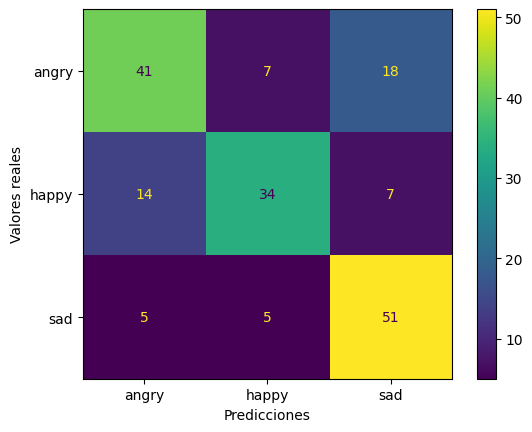

In [292]:
model.eval()
total = 0
correct = 0
y_pred = []
y_real = []
with torch.no_grad():
    for data, target in test_data:
        output = model(data)
        pred = torch.max(output, 1)[1]
    
        batch_size = target.size(0)
        total += batch_size
        correct += (pred == target).float().sum().item()
    
        y_pred.extend(np.array(pred).flatten())
        y_real.extend(np.array(target).flatten())


acc = correct / total
print("Accuracy: {:.6f}".format(acc))

y_real = le.inverse_transform(y_real)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_real, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.show()

La matriz de confusión muestra las predicciones del modelo en relación a las clases reales de los datos de prueba. En este caso, la matriz es de tamaño 3x3 porque el modelo tiene tres clases posibles: **angry**, **happy**, **sad**. Los valores en la diagonal de la matriz representan las predicciones correctas del modelo, mientras que los valores fuera de la diagonal representan las predicciones incorrectas.  En este caso, podemos observar que la clase **angry** fue predicha correctamente 41 veces, pero fue confundida con la clase **happy** en 7 ocasiones y con la clase **sad** en 18 ocasiones. La clase **happy** (segunda fila) fue predicha correctamente 34 veces, pero fue confundida con la clase **angry** en 14 ocasiones y con la clase **sad** en 7 ocasiones. La clase **sad** (tercera fila) fue predicha correctamente 51 veces, pero fue confundida con la clase **angry** en 5 ocasiones y con la clase **happy** en 5 ocasiones. En general, podemos decir que el modelo parece tener un buen desempeño en la clasificación de la clase **sad**, pero tiene más dificultades para distinguir entre las clases **angry** y **happy**.

***
***

## Predicción de Sentimientos Aleatorios.

In [293]:
model.eval()

np.random.seed(0)
size = 3
random_indices = np.random.choice(df.index, size = size, replace = False)
new_X = df.drop(columns = ['label']).take(random_indices).values # type: ignore
new_Y = df['label'].take(random_indices).values # type: ignore

random_values = MyDataset(new_X, new_Y)

random_data = DataLoader(
    random_values,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

y_pred = []
y_real = []

with torch.no_grad():
    for data, target in random_data:
        outputs = model(data)
        pred = outputs.argmax(dim = 1)
        y_pred.extend(np.array(pred).flatten())
        y_real.extend(np.array(target).flatten())
print("La predicción para la muestra elegida es:", le.inverse_transform(y_pred))
print("El valor esperado era: ", le.inverse_transform(y_real))

La predicción para la muestra elegida es: ['happy' 'sad' 'sad']
El valor esperado era:  ['happy' 'sad' 'angry']


***
***

## Conclusiones.

Después de la revisión del código y los resultados obtenidos, podemos concluir lo siguiente:

En primer lugar, considerando que se realiza la identificación y posterior imputación de outliers en los datos utilizando la técnica de imputación de valores faltantes K-Vecinos más Cercanos (KNNImputer) y la prueba de valores Z para la detección de outliers, es posible que la calidad de los datos haya mejorado, lo que puede haber contribuido a la mejora del desempeño del modelo.

En segundo lugar, el conjunto de datos tiene 909 registros, de los cuales 545 se usaron para entrenar el modelo, 182 para validación y 182 para prueba. Aunque esto puede ser un número razonable de datos para algunos problemas, para otros, como la clasificación de emociones, podría ser necesario tener un conjunto de datos más grande para entrenar un modelo que tenga un mejor desempeño. En general es el tamaño del conjunto de entrenamiento, validación y pruebas es adecuado, y la selección de características utilizando la prueba F también puede haber ayudado a mejorar la eficiencia del modelo.

En tercer lugar, la arquitectura de la red neuronal se define mediante la clase Net y EnsembleModel, con una capa de entrada de 17 nodos, dos capas ocultas con 14 y 10 nodos respectivamente, y una capa de salida de 3 nodos. Se entrenaron tres modelos y se combinaron en un modelo de conjunto (EnsembleModel), que se entrenó en los mismos datos. Se utilizaron 100 épocas de entrenamiento y se obtuvo una precisión (accuracy) del 0.692308, razonablemente bueno, pero no suficiente.

En cuarto lugar, la matriz de confusión muestra que el modelo tuvo un rendimiento sólido en la clasificación de la clase sad, pero tuvo dificultades para distinguir entre las clases angry y happy. Estos resultados sugieren que puede haber una superposición entre estas dos clases en términos de las características que el modelo está utilizando para hacer sus predicciones.

Aunque la precisión obtenida no es muy alta, hay que tener en cuenta que la clasificación de emociones es un problema complejo, especialmente si se considera la gran complejidad de las emociones y las diferentes condiciones en las que pueden ser capturadas. Por lo que, si la base de datos no es representativa o está sesgada, el modelo puede tener dificultades para generalizar y producir resultados precisos. Por lo tanto, es importante tener en cuenta la calidad y representatividad de los datos utilizados en el entrenamiento del modelo. Particularmente, parece ser el problema en esa implementación.